# Part I: Research Question
## A1. Proposed Question
What are the principal factors contributing to hospital admissions among different patient groups?

## A2. Goal of the Data Analysis
The goal of this analysis is to reduce the dimensionality of the patient data to uncover the principal factors that impact hospital admissions. This will enable the hospital to allocate resources more efficiently and tailor patient care strategies to reduce admission rates and improve healthcare outcomes.

# Part II: Method Justification

## B1. How PCA Analyzes the Data Set
Principal Component Analysis (PCA) is a statistical technique that emphasizes variation and brings out strong patterns in a dataset. In our situation, PCA transforms patient characteristics and health data into smaller ones that still contain the most information in this large set. The expected outcome is to identify principal components that explain the most variance in the data, providing insights into which factors are most influential.

## B2. Assumption of PCA
**Linearity:** The most fundamental assumption of PCA is that the data is linear, meaning that the data can be described by linear relationships. This implies that the principal components derived represent linear combinations of the original features.

# Part III: Data Preparation


In [1]:
import pandas as pd
from summarytools import dfSummary
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

## C1. Dataset Variables

While applying PCA to discrete or categorical variables is possible, it is generally not recommended. Therefore, we will use the following variables:
* **`Age`(Continuous):** Age is a fundamental variable often correlating with healthcare needs. Different age groups may show distinct patterns of hospital admissions.

* **`Income`(Continuous):** Socioeconomic status, proxied by income, can influence healthcare access, frequency of hospital visits, and types of illnesses or conditions leading to admissions.

* **`VitD_levels`(Continuous):** Vitamin D levels can indicate overall health and specific health conditions, impacting bone health, immune function, and more.

* **`Initial_days`(Continuous):** This reflects the initial length of stay and can provide insights into the severity of the conditions leading to hospital admissions. It also hints at the efficiency of the hospital's care and treatment processes.

* **`TotalCharge`(Continuous):** The total charge for the hospital stay can help identify patterns related to the cost of care, which might correlate with the complexity or severity of conditions treated at the hospital.

* **`Additional_charges`(Continuous):** Similar to `TotalCharge`, this can give further insights into the financial aspects of care, possibly reflecting on additional services or treatments required by certain patient groups.

In [2]:
data = pd.read_csv('medical_clean.csv')

In [3]:
dfSummary(data,is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CaseOrder[int64],Mean (sd) : 5000.5 (2886.9)min < med < max:1.0 < 5000.5 < 10000.0IQR (CV) : 4999.5 (1.7),"10,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Customer_id[object],1. C4124032. D2943643. B2032104. C201775. K2160206. O8966257. M3047798. H894379. A14383410. L21446011. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)9,990 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
3,Interaction[object],1. 8cd49b13-f45a-4b47-a2bd-173ffa2. dc1799a6-61d1-44a3-9b94-b895843. dc6bab10-659b-4c78-ba87-87ffa34. 1cb70cc8-47b7-4192-8bed-faad0f5. 06d0da86-5600-472d-a35d-7632776. 18b8277b-c5aa-4f80-8439-b12ad87. 32cb2440-1fda-4ed6-b00b-2829bf8. 344ea878-976d-469b-8332-e1b1ab9. 52e1962b-8ed4-447a-a818-df09c210. 8ce5b34d-efff-4229-b23e-5510e211. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)9,990 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI

In [4]:
data['Age'] = data['Age'].astype('float64')
data = data.select_dtypes(include=['float64'])
df=data.copy()
df.drop(columns=['Lat','Lng'],inplace=True)

### Testing for Correlation
PCA assumes components are orthogonal, meaning they are uncorrelated with each other. Removing correlated variables helps in simplifying the data by reducing redundancy.

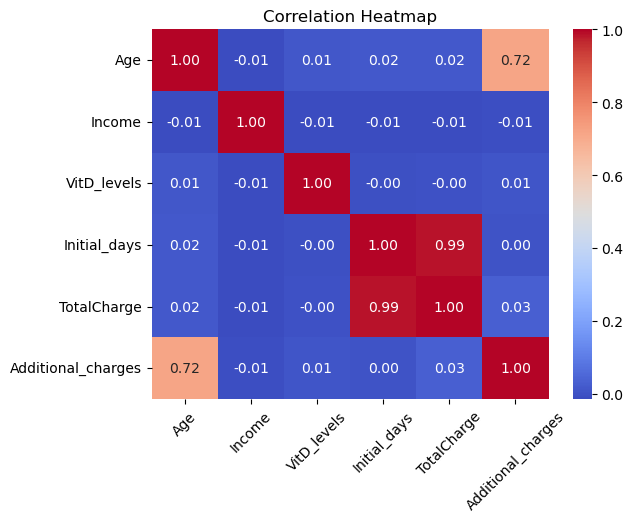

In [5]:
# Compute the correlation matrix
corr_matrix = df[df.columns].corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Dropping strongly correlated features
df = df.drop(columns=['TotalCharge','Additional_charges'])

## C2: Standardizing

In [7]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
dfSummary(pd.DataFrame(data_scaled, columns=df.columns))

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[float64],Mean (sd) : 0.0 (1.0)min < med < max:-1.7 < -0.0 < 1.7IQR (CV) : 1.7 (0.0),72 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3asU/bQBiG8e8Sgi6E2gpJYcvSEalDJBaWbh37x3bt1iFInRm6dGJBSMgkiksUY6dDkaoONPY5Jn2t57eGL3Z0z+ELwm02GwP+d5193wBQxsG+bwDt4Zzrm9lh4Ph6s9k8vvQioWInnHP90Wj0KYqiYcj8YrFInHOfX4p1a6hN7hK0ymEURcPLy8vHOI5XVQbn87mfzWbD+/v7QzOrHmrTuwTtE8fx6vT09GfAaP9fL277jdroLgHKKnVGbWqXYPfaelRr7Zepmgtm9vtPd0Xg7F4WvM1HtUZDzfO8Z2aRcy70LUJj8ScnJx/jOB6EXDTP816apu+Oj49/dDqdrOr8w8PD0jn3xcwqHZee1Ym8tUe1xkJN07SXZdn7yWTS7Xa7lResTixZlnkzO7+4uPg2Ho8XVa99c3MzvL6+fjudTr+fnZ0lVWZvb2/fXF1dfZhMJuOQz10z8qgoil4cx0nbjmqNhbperw+890fT6XRVdbHN6sXyPHvkvc9CFixJkr6Z2WAwqHw2T5KkH/q560aeZZnP8/x8tVp9NbPKn7vmEzAqiqIXMlhG42fUkMU2qx9L1evt2mtHbvZngz49PXWrztZ9AtbdJNu09suUsrqbO8SOnoBBm6QMQsVf9rFJyuC/pyCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHhoMwPzedzX/WNl8ulNzNL09Tf3d0dvea86rVV77vufJm+fgFFPnL1B2RO9gAAAABJRU5ErkJggg=="">",0(0.0%)
2,Income[float64],Mean (sd) : 0.0 (1.0)min < med < max:-1.4 < -0.2 < 5.8IQR (CV) : 1.2 (0.0),"9,993 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3cMW/aQBiA4e9KQAYiAyKCjZWhUgdGlv6D/tiu3YrEjsQ/YEMyGIQbB2PcKVPTJNzZ6X3u++xnbnhldHB3pigKAXz36V9PAHiPuyofboxpi0jL4RHnoigey5oP9KosVGNMezgcfgvDcGD7jOPxuDfGfCdWVPlGbYVhOJjP54+9Xi+9dfDhcAiWy+UgiqKWiBDqf67Sr34RkV6vl45Go1+Ww9ulTgZqsZiCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQpv/jPlsLEkvF6vTYtxwB9eDdVlY0mWZUGe55/TNP0pIrZ/oQIi8vYb1XpjyWazGazX687lcmk4zA8QkXduSrHZWLLf79lQgtKwmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFSo/1+8iz/OmiITGGJvhXAdUI96GmiRJM8uyL5PJpNFoNG6+aYXrgOrF21DP5/NdEASd2WyWjsfj/S1juQ6ofrwN9Vm327W9EojdWzXCYgoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQre70e15XiMRYSjLF6pZaiux1hEOMrim1qG6nKMRYSjLD6qZajPHI6xiHCUxSsspqACoUIFQoUKhAoVCBUqECpUIFSoQKhQodY/+Lvgyku/EOoLuPLSP4T6Aq689A+hvoIrL/3BYgoq8EatAAux8hFqyViIVYNQS+a6EFssFqMoih6MMUfbKdQxckKtiM1CrIwjNHEcn4wxP0TEZry3kb8r1MPhENz64NPpFIiIJEkSbLfbzkeO1/rZu93uPgiCznQ6Nf1+/+mWsSIicRzfr1arr5PJ5MEmdMfIXT0VRfHXz/0NFyk98m/OwwoAAAAASUVORK5CYII="">",0(0.0%)
3,VitD_levels[float64],Mean (sd) : -0.0 (1.0)min < med < max:-4.0 < -0.0 < 4.2IQR (CV) : 1.3 (-0.0),"9,976 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3csY7aQBCA4dn4IAYSW4AEHS9wUgpK+rR52LTpUlBczRvQIAQyIHznYIzTpYLk8Jqws/xfP6ctfp1s3+2YsiwFcN2Hex8AeI+nex/AVcaYlog0K44fyrJ8q/M8j45QzzDGtPr9/rcoirpV5ne7XWKM+U6s9SHU85pRFHUnk8lbHMfZNYPb7TacTqfd9XrdFBFCrQmh/kUcx9lgMHitMNqq/TAPjpcpqECoUIFQoQLPqDdQFEVDRCJjTJVxPm2dQag1S9O0kef5l9FoFARBcNUXAxE+bV1CqDU7HA5PYRi2x+NxNhwOk2tm+bR1GaHeSKfT4dNWjXiZggqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVPD2cp/l2sjodDo16jwP7HgZqu3ayDzPw6IonrMs+ykiVW6SomZehioWayNFRObzeXc2m7WPx2Nwi8Pher6GKiLV10YmScLdesfwMgUVvP6NqpHlgjURT5esEapDbBesifi7ZI1QHWKzYE3E7yVrhOogiwVrIp4uWeNlCioQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFZz+x2mLJRIskPCMs6HaLJFggYR/nA1VLJZIsEDCPy6HKiLVlkg88gIJy+vWzl61dj5UvJ/tdWuXr1oTqkdsrlu7ftWaUD1kcd3a2UcmvqNCBUKFCoQKFW76jMp6cl1c3iT4z1CNMaGIfKzws8Ner/c1juNPFWb//HVptVq9XDu73+9DEZE0TcPlctn+n/P3mrWdXywWn203CW42m70x5oeIVJn/VZblxbnfLfkrwSxU0C0AAAAASUVORK5CYII="">",0(0.0%)
4,Initial_days[float64],Mean (sd) : -0.0 (1.0)min < med < max:-1.3 < 0.1 < 1.4IQR (CV) : 2.0 (-0.0),"9,997 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEU

## Part IV: Analysis

In [8]:
pca = PCA()
pca.fit(data_scaled); 

In [9]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Creating a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df.columns)

loadings_df

,PC1,PC2,PC3,PC4
Age,-0.585240,-0.115179,0.660945,-0.455500
Income,0.567247,-0.158736,0.715313,0.376112
VitD_levels,-0.369666,0.755615,0.173078,0.512383
Initial_days,-0.480517,-0.628406,-0.093717,0.604587


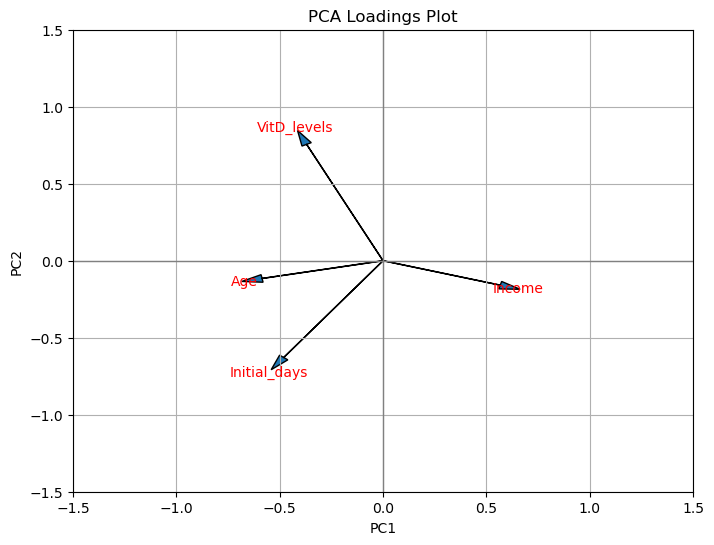

In [10]:
# Plotting the loadings
plt.figure(figsize=(8, 6))
for i in range(len(loadings_df)):
    plt.arrow(0, 0, loadings_df.PC1[i], loadings_df.PC2[i], head_width=0.05, head_length=0.1)
    plt.text(loadings_df.PC1[i] * 1.15, loadings_df.PC2[i] * 1.15, loadings_df.index[i], color='red', ha='center', va='center')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Loadings Plot")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

## Elbow Plot Identifying Number of Principal Components

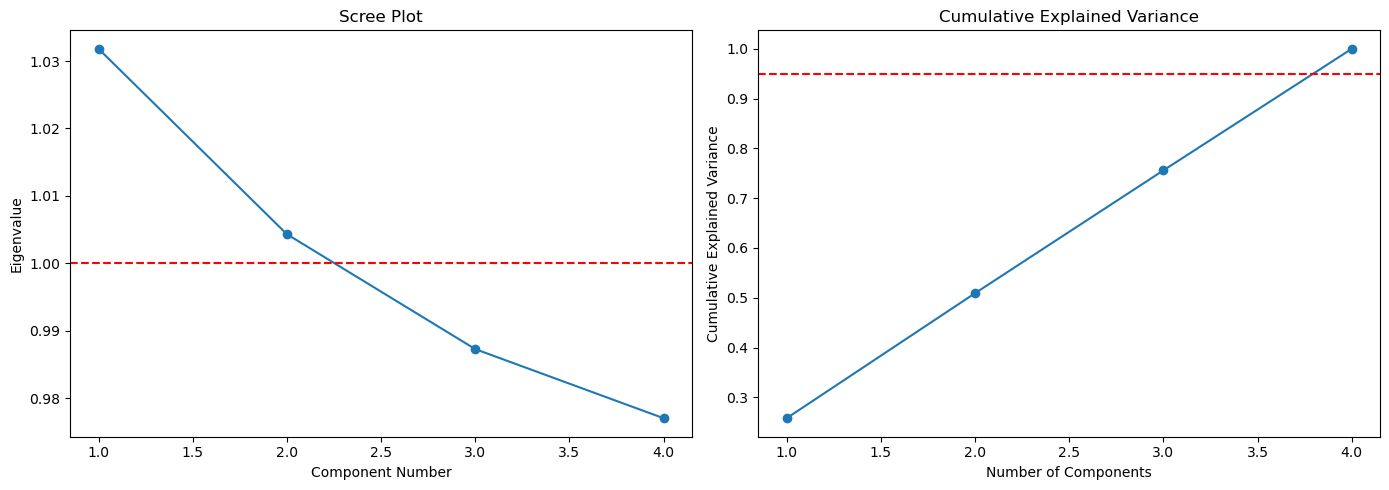

In [11]:
pca = PCA().fit(data_scaled)

plt.figure(figsize=(14, 5))

# Left plot (Scree plot)
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')

# Right plot (Cumulative Explained Variance)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to indicate the 95% variance explained threshold
plt.tight_layout()
plt.show()

### Interpretation

**Equal Distribution of Variance:** A linear plot suggests that each principal component contributes almost equally to explaining the variance in the data. This is unusual because, typically, earlier components capture more variance due to the way PCA prioritizes the direction of maximum variance.

**Lack of Dominant Features:** The linear increase in explained variance suggests that no dominant features capture a significant amount of information in the dataset. Instead, most features contribute similarly to the variance, as demonstrated in the cells below.

In [12]:
print(f"Contribution Breakdown:")
pc_contributions = list(pca.explained_variance_ratio_)
pc_names = list(loadings_df.columns)
for i in range(len(pc_names)):
    print(f"{pc_names[i]}: {round(pc_contributions[i] * 100, 3)}%")

Contribution Breakdown:
PC1: 25.793%
PC2: 25.105%
PC3: 24.679%
PC4: 24.423%


**Dimension Reduction Strategy:** Since the goal is to reduce dimensionality without losing significant information, retaining the correlated variables will help identify components that capture substantial variance. However, it is worth noting that if the principal components are used as predictors in regression models, this can lead to redundancy and potential multicollinearity in subsequent analyses.

In [13]:
df=data[['Age','Income','VitD_levels','Initial_days','TotalCharge','Additional_charges']]
df.head()


,Age,Income,VitD_levels,Initial_days,TotalCharge,Additional_charges
0,53.0,86575.93,19.141466,10.585770,3726.702860,17939.403420
1,51.0,46805.99,18.940352,15.129562,4193.190458,17612.998120
2,53.0,14370.14,18.057507,4.772177,2434.234222,17505.192460
3,78.0,39741.49,16.576858,1.714879,2127.830423,12993.437350
4,22.0,1209.56,17.439069,1.254807,2113.073274,3716.525786


In [14]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [15]:
# Output Standarized Data

# data_scaled_df = pd.DataFrame(data_scaled,columns=df.columns)
# data_scaled_df.to_csv('processed_data.csv')

In [16]:
pca = PCA()
pca.fit(data_scaled);

## Revised Principal Component Matrix


In [17]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Creating a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'], index=df.columns)
display(loadings_df)

,PC1,PC2,PC3,PC4,PC5,PC6
Age,0.121178,0.918361,0.018052,0.001086,0.376423,0.002846
Income,-0.029431,-0.024631,0.705365,0.707874,0.001207,0.000139
VitD_levels,-0.002371,0.025223,-0.716987,0.696697,-0.000993,-0.000168
Initial_days,0.989668,-0.119729,0.008332,0.011055,0.016868,-0.076464
TotalCharge,0.991255,-0.105924,0.005966,0.011329,-0.016742,0.076486
Additional_charges,0.121455,0.918359,0.022333,0.001512,-0.376096,-0.003985


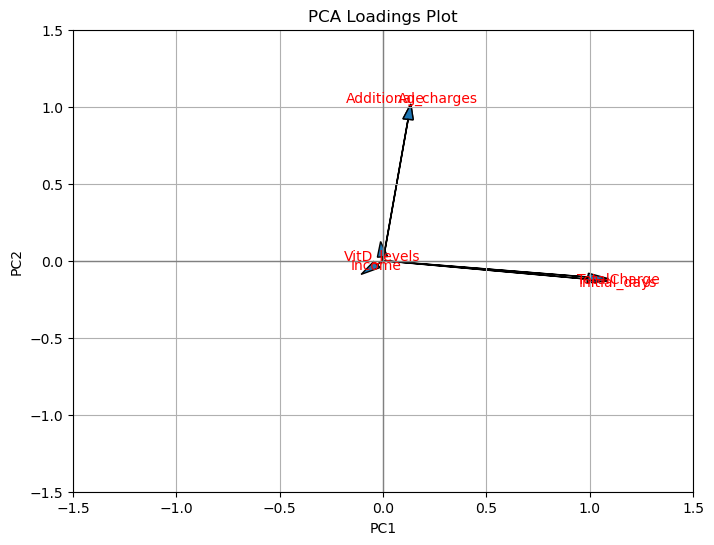

In [18]:
# Plotting the loadings
plt.figure(figsize=(8, 6))
for i in range(len(loadings_df)):
    plt.arrow(0, 0, loadings_df.PC1[i], loadings_df.PC2[i], head_width=0.05, head_length=0.1)
    plt.text(loadings_df.PC1[i] * 1.15, loadings_df.PC2[i] * 1.15, loadings_df.index[i], color='red', ha='center', va='center')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Loadings Plot")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

### Understanding Overlapping Vectors in PCA
**Directional Alignment:** In PCA, each vector represents the direction and magnitude of a variable's contribution to a principal component. If two vectors are pointing in roughly the same direction or overlapping, these variables contribute similarly to the component, indicating a potential correlation between them.

**Correlation Implications:**

- **Positive Correlation:** Vectors that align closely in the same direction suggest a positive correlation, meaning the variables increase together.

- **Negative Correlation:** Vectors that point in opposite directions suggest a negative correlation, indicating that the other decreases as one variable increases.

- **Magnitude and Importance:** The length of the vectors indicates the strength of the variable's contribution to the principal component. Longer vectors have a more significant influence on the component.

### Why This Matters
PCA aims to reduce the number of variables while retaining as much information as possible. Correlated variables carry similar information, so PCA captures this information with fewer components.


## Revised Elbow Plot Identifying Number of Principal Components

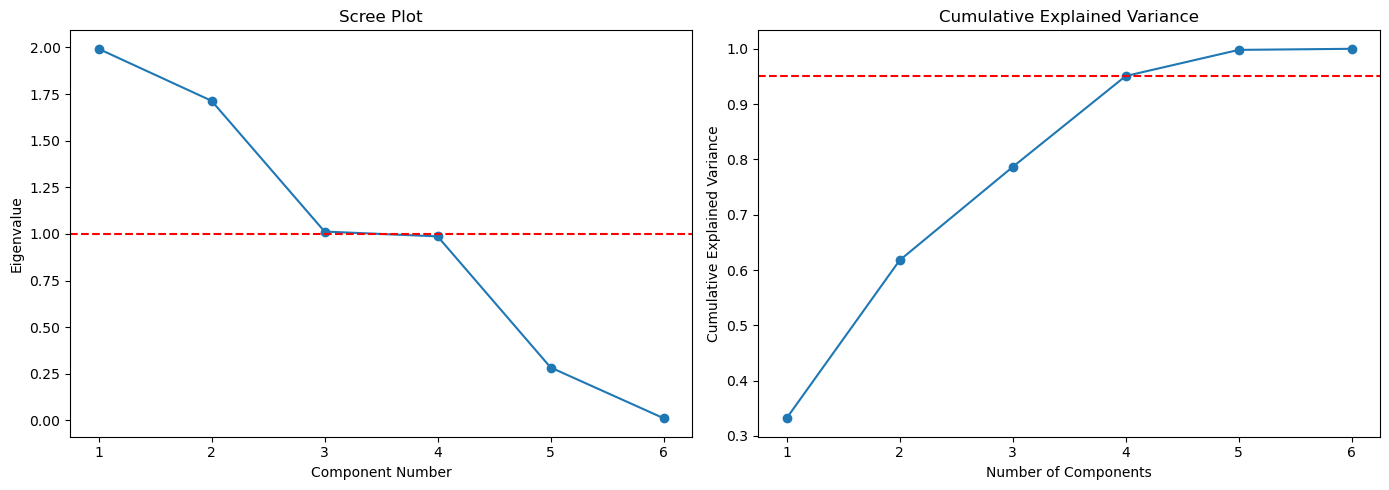

In [19]:
pca = PCA().fit(data_scaled)

plt.figure(figsize=(14, 5))

# Left plot (Scree plot)
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')

# Right plot (Cumulative Explained Variance)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Line to indicate the 95% variance explained threshold
plt.tight_layout()
plt.show()

## D4: Total Variance

In [20]:
print(f"Contribution Breakdown:")
pc_contributions = list(pca.explained_variance_ratio_)
pc_names = list(loadings_df.columns)
for i in range(len(pc_names)):
    print(f"{pc_names[i]}: {round(pc_contributions[i] * 100, 3)}%")

Contribution Breakdown:
PC1: 33.202%
PC2: 28.557%
PC3: 16.874%
PC4: 16.444%
PC5: 4.728%
PC6: 0.195%


### Decision Criteria
A common practice is to select enough components to explain a substantial portion of the variance, typically 70-95%. In this case, the first four components explain about 95% of the variance, which is usually sufficient for most applications.

- **PC1 through PC4:** Together, these four components explain 33.202%+28.557%+16.874%+16.444%≈95.077% of the variance. 
- **PC5:** Adds about 4.728%, bringing the total explained variance to just under 100% when combined with the first four components.
- **PC6:** Contributes very little to the variance (0.195%)


## D5: Analysis Results

The loadings of each variable on the principal components describe the correlation between the original variables and the component.

- **PC1 Strong Loadings:** `Initial_days` (0.989668) and `TotalCharge` (0.991255)
    - **Interpretation:** PC1 is dominated by `Initial_days` and `TotalCharge`. This suggests that the initial duration of hospital stay and the total charges are closely related and contribute significantly to hospital admissions. This component might represent the financial or cost-related aspect of hospital stays.
- **PC2 Strong Loadings:** `Age` (0.918361) and `Additional_charges` (0.918359)
    - **Interpretation:** PC2 is heavily influenced by `Age` and `Additional_charges`. This component might represent demographic-related factors, where age significantly impacts the additional costs incurred, potentially reflecting treatments for age-related conditions or the complexity of care required as age increases.
- **PC3 and PC4 Strong Loadings**
    - PC3: `Income` (0.705365) and `VitD_levels` (-0.716987)
    - PC4: `Income` (0.707874) and `VitD_levels` (0.696697)
    - **Interpretation:** These components show a significant contribution from `Income` and `VitD_levels`, but in opposing directions for PC3 and similarly for PC4. These might represent health-related factors influenced by socioeconomic status (as suggested by `Income`) and health condition (as indicated by `VitD_levels`). Interestingly, vitamin D levels and income appear inversely related in one component and directly related in another, suggesting complex interactions between socioeconomic status and health parameters.
- **PC5 and PC6**
These components contribute relatively minor amounts compared to the first four PCs, indicating that they capture less significant residual variance.

### Principal Factors:
- **Cost Factors:** `Initial_days` and `TotalCharge` are significant contributors, suggesting that the length of stay and associated costs are critical in determining hospital admissions.
- **Demographic and Health Factors:** `Age` and `Additional_charges` highlight the impact of age and possibly the complexity or intensity of treatments as patients age.
- **Socioeconomic and Health Status:** `Income` and `VitD_levels` indicate that economic factors coupled with basic health indicators like vitamin D levels play a role in hospital admissions.

### Implications for Patient Groups:
These factors might characterize different patient groups. For instance, older patients might face higher charges due to longer stays or more intensive treatment needs. Similarly, patients from lower-income backgrounds might experience different admission patterns due to their economic constraints and health conditions.
### Strategies for Hospital Administration:
**Developing targeted strategies** For patient care, considering these principal factors could help optimize resources and improve care delivery. For example, preventive care initiatives could address vitamin D deficiency in lower-income groups to reduce the necessity for prolonged hospital stays.

**Further Research and Data Collection:**
Additional research into how these factors impact patient outcomes could refine strategies further. Collecting more detailed data on patient health metrics and socioeconomic factors could also provide deeper insights.
This analysis helps you understand the multidimensional factors influencing hospital admissions and tailor your approaches to address the diverse needs of different patient groups. This could potentially lead to more effective and efficient healthcare delivery.